# Layer Normalization
# 层标准化

# Abstract
# 摘要

Training state-of-the-art, deep neural networks is computationally expensive. One way to reduce the training time is to normalize the activities of the neurons. A recently introduced technique called batch normalization uses the distribution of the summed input to a neuron over a mini-batch of training cases to compute a mean and variance which are then used to normalize the summed input to that neuron on each training case. This significantly reduces the training time in feedforward neural networks. However, the effect of batch normalization is dependent on the mini-batch size and it is not obvious how to apply it to recurrent neural networks. In this paper, we transpose batch normalization into layer normalization by computing the mean and variance used for normalization from all of the summed inputs to the neurons in a layer on a single training case. Like batch normalization, we also give each neuron its own adaptive bias and gain which are applied after the normalization but before the non-linearity. Unlike batch normalization, layer normalization performs exactly the same computation at training and test times. It is also straightforward to apply to recurrent neural networks by computing the normalization statistics separately at each time step. Layer normalization is very effective at stabilizing the hidden state dynamics in recurrent networks. Empirically, we show that layer normalization can substantially reduce the training time compared with previously published techniques.

训练最先进的深度神经网络在计算上是昂贵的。减少训练时间的一种方法是使神经元的活动正常化。最近引进的一种叫做“批处理归一化”的技术，是在一小批训练案例的基础上，将输入累加到一个神经元上的数据分布计算出平均值和方差，然后用这些平均值和方差对每个训练案例中输入累加到该神经元上的数据进行归一化。这大大减少了前馈神经网络的训练时间。然而，批处理归一化的效果取决于小批处理的大小，如何将其应用于递归神经网络还不明显。在本文中，我们在一个单一的训练案例中，通过计算对同一层神经元的所有求和输入的归一化所用的均值和方差，将批量归一化转换为层归一化。像批处理归一化一样，我们也给每个神经元各自的自适应偏差和增益，这些偏差和增益在归一化之后而在非线性之前应用。与批处理规范化不同，层规范化在训练和测试时执行完全相同的计算。通过在每个时间步分别计算归一化统计量，也可以直接应用于递归神经网络。层归一化对于稳定递归网络的隐藏状态是非常有效的。经验表明，与以前发表的技术相比，层标准化可以大大减少训练时间。


# 1 Introduction
# 1 介绍


Deep neural networks trained with some version of Stochastic Gradient Descent have been shown to substantially outperform previous approaches on various supervised learning tasks in computer vision [Krizhevsky et al., 2012] and speech processing [Hinton et al., 2012]. But state-of-the-art deep neural networks often require many days of training. It is possible to speed-up the learning by computing gradients for different subsets of the training cases on different machines or splitting the neural network itself over many machines [Dean et al., 2012], but this can require a lot of communication and complex software. It also tends to lead to rapidly diminishing returns as the degree of parallelization increases. An orthogonal approach is to modify the computations performed in the forward pass of the neural net to make learning easier. Recently, batch normalization [Ioffe and Szegedy, 2015] has been proposed to reduce training time by including additional normalization stages in deep neural networks. The normalization standardizes each summed input using its mean and its standard deviation across the training data. Feedforward neural networks trained using batch normalization converge faster even with simple SGD. In addition to training time improvement, the stochasticity from the batch statistics serves as a regularizer during training.

在计算机视觉(Krizhevsky et al.， 2012)和语音处理(Hinton et al.， 2012)的各种监督学习任务中，使用某种版本的随机梯度下降训练的深度神经网络已被证明大大优于先前的方法。但是最先进的深度神经网络通常需要很多天的训练。可以通过计算不同机器上训练用例的不同子集的梯度来加速学习，或者将神经网络本身拆分到多台机器上[Dean et al.， 2012]，但这需要大量的通信和复杂的软件。随着并行度的增加，它也会导致收益迅速减少。一种正交的方法是修改在神经网络的前向传递中执行的计算，使学习更容易。最近，有人提出批量归一化[Ioffe and Szegedy, 2015]，通过在深度神经网络中加入额外的归一化阶段来减少训练时间。标准化使用每个输入的平均值和它在训练数据上的标准差来标准化每个输入的平均值和它在训练数据上的标准差。使用批处理归一化训练的前馈神经网络即使使用简单的SGD也能更快地收敛。除了训练时间的提高外，训练过程中批量统计数据的随机性也起到了调节作用。

Despite its simplicity, batch normalization requires running averages of the summed input statis￾tics. In feed-forward networks with fixed depth, it is straightforward to store the statistics separately for each hidden layer. However, the summed inputs to the recurrent neurons in a recurrent neural network (RNN) often vary with the length of the sequence so applying batch normalization to RNNs appears to require different statistics for different time-steps. Furthermore, batch normalizaarXiv:1607.06450v1 [stat.ML] 21 Jul 2016 tion cannot be applied to online learning tasks or to extremely large distributed models where the minibatches have to be small.

尽管它很简单，但批处理规范化要求对汇总输入统计的运行平均值进行处理。在具有固定深度的前馈网络中，每一隐含层的统计量都可以直接单独存储。然而，在递归神经网络(RNN)中，对递归神经元的累加输入往往会随着序列的长度而变化，因此对递归神经网络应用批处理归一化似乎需要对不同的时间步长进行不同的统计。此外，批量normalizaarXiv:1607.06450v1 [stat]。2016年7月21日tion不能应用于在线学习任务或极小批量必须很小的超大分布式模型。

This paper introduces layer normalization, a simple normalization method to improve the training speed for various neural network models. Unlike batch normalization, the proposed method directly estimates the normalization statistics from the summed inputs to the neurons within a hidden layer so the normalization does not introduce any new dependencies between training cases. We show that layer normalization works well for RNNs and improves both the training time and the generalization performance of several existing RNN models.

本文介绍了一种简单的层归一化方法——层归一化法，以提高各种神经网络模型的训练速度。与批处理归一化不同，该方法直接从一个隐含层的神经元的累加输入估计归一化统计量，因此归一化不会在训练用例之间引入任何新的依赖关系。结果表明，层归一化方法对神经网络具有良好的效果，提高了现有几种神经网络模型的训练时间和泛化性能。

# 2 Background
# 2 背景


A feed-forward neural network is a non-linear mapping from a input pattern x to an output vector y. Consider the l^th hidden layer in a deep feed-forward, neural network, and let a^l be the vector representation of the summed inputs to the neurons in that layer. The summed inputs are computed through a linear projection with the weight matrix W^l and the bottom-up inputs h^l given as follows:

前馈神经网络是一个从输入模式x到输出向量y的非线性映射，考虑深度前馈神经网络的l^th隐层，让A ^l表示该层中神经元的求和输入的向量。求和输入通过权重矩阵W^l和自底向上输入h^l的线性投影计算如下:

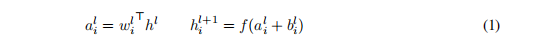

where f(·) is an element-wise non-linear function and w^li is the incoming weights to the i^th hidden units and b^li is the scalar bias parameter. The parameters in the neural network are learnt using gradient-based optimization algorithms with the gradients being computed by back-propagation.

其中f(·)是一个元素向非线性函数，w^li是第i^个隐藏单元的权值，b^li是标量偏置参数。神经网络参数的学习采用基于梯度的优化算法，梯度的计算采用反向传播。

One of the challenges of deep learning is that the gradients with respect to the weights in one layer are highly dependent on the outputs of the neurons in the previous layer especially if these outputs change in a highly correlated way. Batch normalization [Ioffe and Szegedy, 2015] was proposed to reduce such undesirable “covariate shift”. The method normalizes the summed inputs to each hidden unit over the training cases. Specifically, for the i^th summed input in the l^th layer, the batch normalization method rescales the summed inputs according to their variances under the distribution of the data

深度学习的挑战之一是，与一层权重相关的梯度高度依赖于前一层神经元的输出，尤其是当这些输出以高度相关的方式变化时。批量归一化[Ioffe and Szegedy, 2015]被提出以减少这种不希望的“协变量移位”。该方法对训练用例上的每个隐藏单元的求和输入进行规范化。具体来说，对于第l层的i^th求和输入，批处理归一化方法根据数据分布下的方差对求和输入进行重新排序
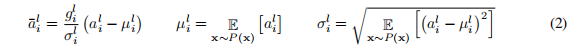

where a¯^li is normalized summed inputs to the i^th hidden unit in the l^th layer and gi is a gain parameter scaling the normalized activation before the non-linear activation function. Note the expectation is under the whole training data distribution. It is typically impractical to compute the expectations in Eq. (2) exactly, since it would require forward passes through the whole training dataset with the current set of weights. Instead, µ and σ are estimated using the empirical samples from the current mini-batch. This puts constraints on the size of a mini-batch and it is hard to apply to recurrent neural networks.

其中¯^li被归一化对l^th层的i^th隐藏单元的输入进行求和，gi是一个增益参数，在非线性激活函数之前对归一化激活进行缩放。注意期望是在整个训练数据分布下。精确地计算Eq.(2)中的期望通常是不切实际的，因为它需要使用当前的权重集向前传递整个训练数据集。相反,µ和σ估计使用当前mini-batch实证样本。这就限制了小型批处理的大小，并且很难应用于递归神经网络。






# 3 Layer normalization
# 3 层标准化


We now consider the layer normalization method which is designed to overcome the drawbacks of batch normalization.

我们现在考虑的层归一化方法，旨在克服批量归一化的缺点。

Notice that changes in the output of one layer will tend to cause highly correlated changes in the summed inputs to the next layer, especially with ReLU units whose outputs can change by a lot. This suggests the “covariate shift” problem can be reduced by fixing the mean and the variance of the summed inputs within each layer. We, thus, compute the layer normalization statistics over all the hidden units in the same layer as follows:

注意到一层的输出的变化往往会引起高度相关总结输入下一层的变化,尤其是ReLU单元的输出可以变化很多。这表明,“协变量转变”的问题可以减少固定的均值和方差求和输入每一层内。因此，计算同一层中所有隐藏单元的层归一化统计量如下:

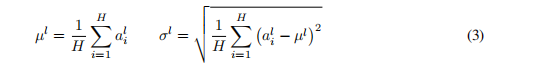

where H denotes the number of hidden units in a layer. The difference between Eq. (2) and Eq. (3) is that under layer normalization, all the hidden units in a layer share the same normalization terms µ and σ, but different training cases have different normalization terms. Unlike batch normalization, layer normaliztion does not impose any constraint on the size of a mini-batch and it can be used in the pure online regime with batch size 1.

式中，H为一层的隐藏单元数。情商的区别。(2)和Eq。(3),在层标准化,所有隐藏的单位在一层共享相同的标准化术语µ和σ,但不同的训练情况下有不同的归一化条件。与批处理规范化不同，层规范化对小批处理的大小没有任何限制，并且可以在批处理大小为1的纯在线状态下使用。

## 3.1 Layer normalized recurrent neural networks
## 3.1层归一化递归神经网络


The recent sequence to sequence models [Sutskever et al., 2014] utilize compact recurrent neural networks to solve sequential prediction problems in natural language processing. It is common among the NLP tasks to have different sentence lengths for different training cases. This is easy to deal with in an RNN because the same weights are used at every time-step. But when we apply batch normalization to an RNN in the obvious way, we need to to compute and store separate statistics for each time step in a sequence. This is problematic if a test sequence is longer than any of the training sequences. Layer normalization does not have such problem because its normalization terms depend only on the summed inputs to a layer at the current time-step. It also has only one set of gain and bias parameters shared over all time-steps.

最近的序列到序列模型[Sutskever et al.， 2014]利用紧凑的递归神经网络来解决自然语言处理中的序列预测问题。在NLP任务中，不同的训练用例有不同的句子长度是很常见的。这在RNN中很容易处理，因为在每个时间步都使用相同的权值。但是当我们以明显的方式对RNN应用批处理规范化时，我们需要为序列中的每个时间步计算和存储单独的统计信息。如果一个测试序列比任何一个训练序列都长，这是有问题的。层归一化不存在这样的问题，因为它的归一化项只依赖于在当前时间步上对层的求和输入。在所有时间步长上，它也只有一组共享的增益和偏差参数。

In a standard RNN, the summed inputs in the recurrent layer are computed from the current input x^t and previous vector of hidden states h^t-1 which are computed as at = Whhh^t-1 + Wxhx^t. The layer normalized recurrent layer re-centers and re-scales its activations using the extra normalization terms similar to Eq. (3):

在一个标准的RNN中，循环层的求和输入是由当前输入的x^t和先前的隐藏状态向量h^t-1计算得到的，计算公式为at = Whhh^t-1 + Wxhx^t。层归一化递归层使用类似于式(3)的额外归一化项重新中心和重新缩放其激活:

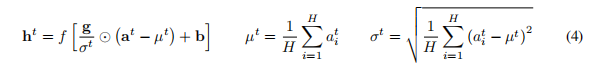

where W_hh is the recurrent hidden to hidden weights and W_xh are the bottom up input to hidden weights. ◎ is the element-wise multiplication between two vectors. b and g are defined as the bias and gain parameters of the same dimension as h^t.

其中W_hh是循环的隐含权值，W_xh是自底向上的隐含权值输入。◎是两个向量之间的元素乘。b和g定义为与h^t相同维度的偏差和增益参数。

In a standard RNN, there is a tendency for the average magnitude of the summed inputs to the recurrent units to either grow or shrink at every time-step, leading to exploding or vanishing gradients. In a layer normalized RNN, the normalization terms make it invariant to re-scaling all of the summed inputs to a layer, which results in much more stable hidden-to-hidden dynamics.

在一个标准的RNN中，对循环单元的求和输入的平均大小在每个时间步上都有增长或收缩的趋势，导致梯度的爆炸或消失。在一层归一化的RNN中，归一化项使得它可以不变地将所有的求和输入重新缩放到一层中，这使得隐藏到隐藏的动态更加稳定。





# 4 Related work
# 4 相关工作


Batch normalization has been previously extended to recurrent neural networks [Laurent et al., 2015, Amodei et al., 2015, Cooijmans et al., 2016]. The previous work [Cooijmans et al., 2016] suggests the best performance of recurrent batch normalization is obtained by keeping independent normalization statistics for each time-step. The authors show that initializing the gain parameter in the recurrent batch normalization layer to 0.1 makes significant difference in the final performance of the model. Our work is also related to weight normalization [Salimans and Kingma, 2016]. In weight normalization, instead of the variance, the L2 norm of the incoming weights is used to normalize the summed inputs to a neuron. Applying either weight normalization or batch normalization using expected statistics is equivalent to have a different parameterization of the original feed-forward neural network. Re-parameterization in the ReLU network was studied in the Pathnormalized SGD [Neyshabur et al., 2015]. Our proposed layer normalization method, however, is not a re-parameterization of the original neural network. The layer normalized model, thus, has different invariance properties than the other methods, that we will study in the following section.

批处理归一化之前已经扩展到递归神经网络[Laurent et al.， 2015, Amodei et al.， 2015, Cooijmans et al.， 2016]。之前的工作[Cooijmans et al.， 2016]表明，通过对每个时间步保持独立的归一化统计量来获得循环批处理归一化的最佳性能。结果表明，将周期性批处理归一化层的增益参数初始化为0.1对模型的最终性能有显著影响。我们的工作也与权重正常化有关[Salimans and Kingma, 2016]。在权值归一化中，引入权值的L2范数代替方差，用于对神经元的求和输入进行归一化。使用期望统计量进行权重归一化或批处理归一化，等价于对原始前馈神经网络进行不同的参数化。在归一化SGD [Neyshabur et al.， 2015]中研究了ReLU网络的再参数化。然而，我们提出的层归一化方法并不是对原始神经网络的重新参数化。因此，层归一化模型具有不同于其他方法的不变性，我们将在下一节中进行研究。

# 5 Analysis
# 5 分析


In this section, we investigate the invariance properties of different normalization schemes.

在本节中，我们研究了不同归一化格式的不变性。


## 5.1 Invariance under weights and data transformations
## 5.1权重和数据转换下的不变性


The proposed layer normalization is related to batch normalization and weight normalization. Although, their normalization scalars are computed differently, these methods can be summarized as normalizing the summed inputs ai to a neuron through the two scalars µ and σ. They also learn an adaptive bias b and gain g for each neuron after the normalization.

提出的层归一化涉及批处理归一化和权值归一化。虽然,他们的正常化标量计算不同,这些方法可以概括为规范总结输入人工智能神经元通过两个标量µ和σ。他们还学习了自适应偏差b，并在归一化后为每个神经元获得g。

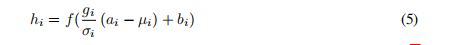

Note that for layer normalization and batch normalization, µ and σ is computed according to Eq. 2 and 3. In weight normalization, µ is 0, and σ = ||w||2.

注意,对于层标准化和批处理规范化,µ和σ计算根据情商,2和3。在体重正常化,µ0,σ= ||w|| 2。

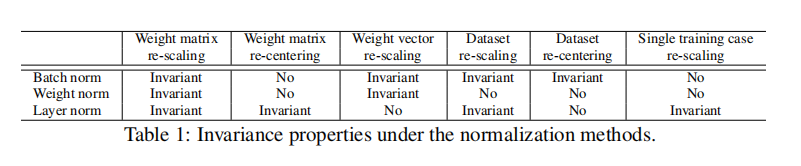

Weight re-scaling and re-centering: First, observe that under batch normalization and weight normalization, any re-scaling to the incoming weights wi of a single neuron has no effect on the normalized summed inputs to a neuron. To be precise, under batch and weight normalization, if the weight vector is scaled by δ, the two scalar µ and σ will also be scaled by δ. The normalized summed inputs stays the same before and after scaling. So the batch and weight normalization are invariant to the re-scaling of the weights. Layer normalization, on the other hand, is not invariant to the individual scaling of the single weight vectors. Instead, layer normalization is invariant to scaling of the entire weight matrix and invariant to a shift to all of the incoming weights in the weight matrix. Let there be two sets of model parameters θ, θ' whose weight matrices W and W' differ by a scaling factor δ and all of the incoming weights in W' are also shifted by a constant vector γ, that is W' = δW + lγ^T. Under layer normalization, the two models effectively compute the same output:

权值重新缩放和重新定心:首先，观察在批处理归一化和权值归一化下，对单个神经元的传入权值wi进行任何缩放，都不会对神经元的归一化和输入产生影响。更精确地说,下批处理和体重正常化,如果权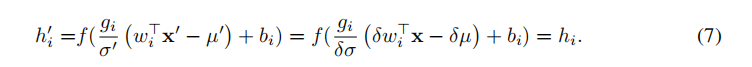重向量乘以δ,两个标量µ和σδ也将扩大。标准化和输入在缩放前后保持不变。因此批处理和权重规范化对于权重的重新缩放是不变的。另一方面，层标准化对于单个权重向量的单独缩放不是不变的。相反，层标准化对于整个权重矩阵的缩放是不变的，对于向权重矩阵中的所有传入权重的移动也是不变的。要有两套模型参数θ,θ的权重矩阵W和W的不同比例因子δ和所有传入的重量W”也将通过一个常数向量γ,即W ' =δW + lγ^ T。在层归一化下，两个模型可以有效地计算出相同的输出:

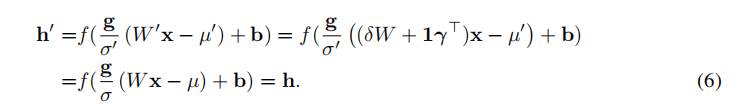

Notice that if normalization is only applied to the input before the weights, the model will not be invariant to re-scaling and re-centering of the weights.

注意，如果归一化只应用于权重之前的输入，那么模型对于权重的重新缩放和重新定心就不是不变的。

Data re-scaling and re-centering: We can show that all the normalization methods are invariant to re-scaling the dataset by verifying that the summed inputs of neurons stays constant under the changes. Furthermore, layer normalization is invariant to re-scaling of individual training cases, because the normalization scalars µ and σ in Eq. (3) only depend on the current input data. Let x' be a new data point obtained by re-scaling x by δ. Then we have,

数据重新缩放和重新定心:通过验证神经元的累加输入在变化下保持不变，可以看出所有的归一化方法对于重新缩放数据集都是不变的。此外,层正常化不变re-scaling个人培训的情况下,因为正常化标量µ和σEq。(3)只取决于当前的输入数据。让x”是一种新的数据点通过re-scalingδx。然后我们有,

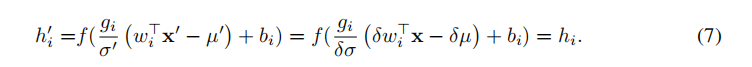

It is easy to see re-scaling individual data points does not change the model’s prediction under layer normalization. Similar to the re-centering of the weight matrix in layer normalization, we can also show that batch normalization is invariant to re-centering of the dataset.

可见，在层归一化条件下，重新缩放单个数据点并没有改变模型的预测。与分层归一化中权矩阵的重新归一化相似，我们也可以证明批处理归一化对数据集的重新归一化是不变的。


## 5.2 Geometry of parameter space during learning
## 5.2学习过程中参数空间的几何化

We have investigated the invariance of the model’s prediction under re-centering and re-scaling of the parameters. Learning, however, can behave very differently under different parameterizations, even though the models express the same underlying function. In this section, we analyze learning behavior through the geometry and the manifold of the parameter space. We show that the normalization scalar σ can implicitly reduce learning rate and makes learning more stable.

研究了模型预测在参数重新定心和缩放时的不变性。然而，学习在不同的参数化下可能表现得非常不同，即使模型表达了相同的底层功能。在这一部分中，我们通过几何和参数空间的流形来分析学习行为。我们表明,归一化标量σ可以隐式地减少学习速率,使学习更加稳定。

### 5.2.1 Riemannian metric
### 5.2.1 黎曼度量

The learnable parameters in a statistical model form a smooth manifold that consists of all possible input-output relations of the model. For models whose output is a probability distribution, a natural way to measure the separation of two points on this manifold is the Kullback-Leibler divergence between their model output distributions. Under the KL divergence metric, the parameter space is a Riemannian manifold.

统计模型中的可学习参数形成光滑流形，包含模型的所有可能的输入-输出关系。对于输出是概率分布的模型，测量两点在流形上的分离的一种自然方法是它们的模型输出分布之间的Kullback-Leibler散度。在KL散度度量下，参数空间是一个黎曼流形。

The curvature of a Riemannian manifold is entirely captured by its Riemannian metric, whose quadratic form is denoted as ds^2 . That is the infinitesimal distance in the tangent space at a point in the parameter space. Intuitively, it measures the changes in the model output from the parameter space along a tangent direction. The Riemannian metric under KL was previously studied [Amari,1998] and was shown to be well approximated under second order Taylor expansion using the Fisher information matrix:

黎曼流形的曲率完全由它的黎曼度量来表示，黎曼度量的二次形式记为ds^2。这是参数空间中一点在切线空间中的无穷小距离。直观地，它测量了参数空间沿切线方向的模型输出的变化。KL下的黎曼度量之前已经被研究过[Amari,1998]，并被证明在二阶泰勒展开式下使用Fisher信息矩阵可以很好地近似:


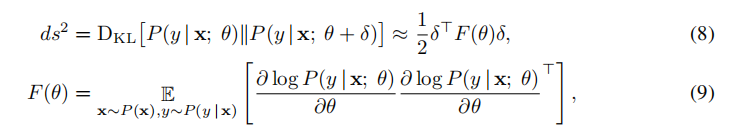

where, δ is a small change to the parameters. The Riemannian metric above presents a geometric view of parameter spaces. The following analysis of the Riemannian metric provides some insight into how normalization methods could help in training neural networks.

在那里,δ是一个小的改变参数。上面的黎曼度量给出了参数空间的几何视图。下面对黎曼度量的分析提供了一些关于规范化方法如何帮助训练神经网络的见解。

### 5.2.2 The geometry of normalized generalized linear models
### 5.2.2归一化广义线性模型的几何性质


We focus our geometric analysis on the generalized linear model. The results from the following analysis can be easily applied to understand deep neural networks with block-diagonal approximation to the Fisher information matrix, where each block corresponds to the parameters for a single neuron.

我们把几何分析集中在广义线性模型上。以下分析的结果可以很容易地应用于理解具有块对角逼近Fisher信息矩阵的深度神经网络，其中每个块对应于单个神经元的参数。

A generalized linear model (GLM) can be regarded as parameterizing an output distribution from the exponential family using a weight vector w and bias scalar b. To be consistent with the previous sections, the log likelihood of the GLM can be written using the summed inputs a as the following:

广义线性模型(GLM)可以被视为参数化输出分布指数家庭使用的权向量w和偏见标量b。与前面一致,日志的可能性的漠视,可以编写使用总结输入如下:

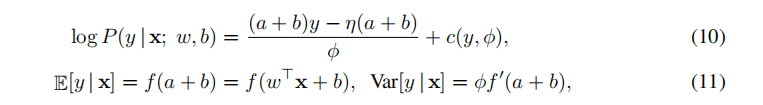



